In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import random
import string
from itertools import islice
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Функции для сохранения и загрузки модели
def save_model(vectorizer, cls_model):
    os.makedirs("./cache/weak_password", exist_ok=True)
    with open("./cache/weak_password/vectorizer.pickle", "wb") as pickle_file:
        pickle.dump(vectorizer, pickle_file)
    with open("./cache/weak_password/svm_clf.pickle", "wb") as pickle_file:
        pickle.dump(cls_model, pickle_file)

In [3]:
def load_model():
    with open("./cache/weak_password/vectorizer.pickle", "rb") as pickle_file:
        vectorizer = pickle.load(pickle_file)
    with open("./cache/weak_password/svm_clf.pickle", "rb") as pickle_file:
        cls_model = pickle.load(pickle_file)
    return vectorizer, cls_model

In [4]:
# Функция для токенизации паролей
def get_tokens(input_string):
    return list(input_string)

In [5]:
# Векторизация данных
def make_vector(passwords, labels):
    vectorizer = TfidfVectorizer(ngram_range=(2, 5), min_df=2, max_df=0.7, lowercase=False,
                                 tokenizer=get_tokens, decode_error='replace', encoding="utf-8")
    X = vectorizer.fit_transform(passwords)
    return X, labels, vectorizer

In [ ]:
# Обучение модели
def train_and_eval(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    model = LinearSVC(class_weight="balanced", random_state=42) #class_weight="balanced", random_state=42
    #model = MultinomialNB(alpha=0.7)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    print(classification_report(y_test, pred, digits=4))

    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Weak', 'Medium', 'Strong'], yticklabels=['Weak', 'Medium', 'Strong'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return model

In [7]:
# Оценка модели на новых паролях
def eval(vectorizer, model):
    
    passwords_to_predict = [
        "simple",           # Weak (Class 0)
        "MediumP1",         # Medium (Class 1)
        "!StrongPassWord111!",     # Strong (Class 2)
        "TestAcc9",         # Medium (Class 1)
        "onlylowercase",    # Weak (Class 0)
        "**Top_Secret@9876A",  # Strong (Class 2)
        "1234567",          # Weak (Class 0)
        "TestUser2",        # Medium (Class 1)
        "^MySecure$Code12@"   # Strong (Class 2)
    ]
    
    X_predict = vectorizer.transform(passwords_to_predict)
    y_Predict = model.predict(X_predict)

    for pwd, pred in zip(passwords_to_predict, y_Predict):
        strength = "Strong" if pred == 2 else 'Medium' if pred == 1 else "Weak"
        print(f'Password: {pwd} -> Prediction: {strength}')

In [8]:
# Загрузка паролей из RockYou и генерация меток
def load_rockyou_data(rockyou_filepath, limit=10000):
    with open(rockyou_filepath, 'r', encoding='latin-1') as file:
        passwords = file.readlines()

    passwords = [pwd.strip() for pwd in passwords]
    labels = [2 if (len(pwd) >= 10 and any(c.isdigit() for c in pwd) and any(c.isupper() for c in pwd) and any(c in set(string.punctuation) for c in pwd)) else 
              1 if (8 <= len(pwd) < 10 and any(c.isdigit() for c in pwd) and any(c.isupper() for c in pwd)) else 
              0 for pwd in passwords]  
    return passwords, labels

In [11]:
rockyou_filepath = os.path.join("C:/Users/Ксения/PycharmProjects/deep_learning/rockyou.txt")
passwords, labels = load_rockyou_data(rockyou_filepath)
counts = Counter(labels)
counts

Counter({0: 13947563, 1: 359534, 2: 37294})

In [33]:
for i in random.sample(range(len(passwords)), 15):
    print(f"Password: {passwords[i]}, Label: {labels[i]}")

Password: apostolos, Label: 0
Password: tip12345, Label: 0
Password: 0728266145, Label: 0
Password: fatita015, Label: 0
Password: broberts0215, Label: 0
Password: garage45., Label: 0
Password: honeyalvin, Label: 0
Password: 143Jesusc, Label: 1
Password: 1xwfgpb74f1i, Label: 0
Password: gysschlossweg7, Label: 0
Password: VEGA72YO, Label: 1
Password: chloecox, Label: 0
Password: daewoo93, Label: 0
Password: 070202719, Label: 0
Password: ana1980, Label: 0


In [ ]:
# from imblearn.over_sampling import SMOTE

# # Тренировка модели
X, y, vectorizer = make_vector(passwords, labels)

# smote = SMOTE(sampling_strategy='auto', random_state=42)  # Примерно уравняем баланс
# X, y = smote.fit_resample(X, y)


c:\Users\Ксения\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [14]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(sampling_strategy={0: 35000, 1: 35000, 2: 35000}, random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)


In [16]:
# counts_new = Counter(X_resampled)
# counts_new

              precision    recall  f1-score   support

           0     0.8838    0.9114    0.8974      8755
           1     0.8340    0.8532    0.8435      8765
           2     0.8867    0.8386    0.8620      8730

    accuracy                         0.8677     26250
   macro avg     0.8682    0.8677    0.8676     26250
weighted avg     0.8682    0.8677    0.8676     26250



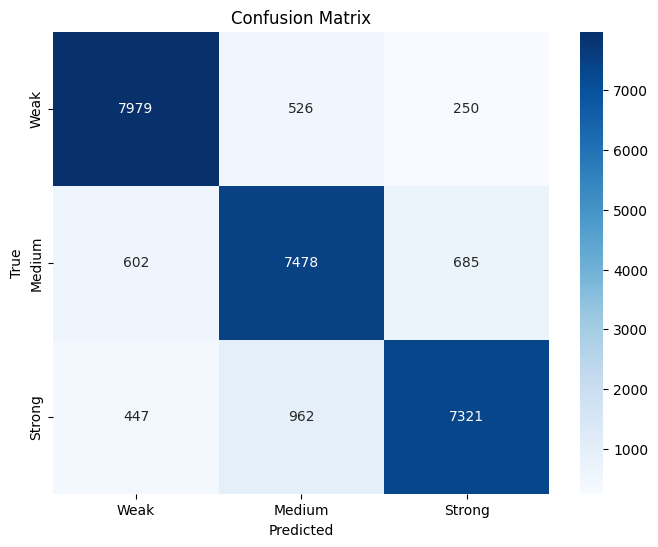

Password: simple -> Prediction: Weak
Password: MediumP1 -> Prediction: Medium
Password: !StrongPassWord111! -> Prediction: Strong
Password: TestAcc9 -> Prediction: Medium
Password: onlylowercase -> Prediction: Weak
Password: **Top_Secret@9876A -> Prediction: Strong
Password: 1234567 -> Prediction: Weak
Password: TestUser2 -> Prediction: Medium
Password: ^MySecure$Code12@ -> Prediction: Strong


In [ ]:
# probs = cls_model.predict_proba(X_)
# for prob in probs[:10]:
#     print([f"{p:.3f}" for p in prob])